# Intrinsic Dimension

In [1]:
import os
import sys
import math
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.cluster import KMeans

sys.path.append(str(Path.cwd().parent))
from utils.train_val import train_net #, train_epoch, validate_epoch, save_checkpoint
from utils.data_loaders import mnist_loaders

# sys.path.append(str(Path.cwd().parent.parent))
# from pytorch_testing.tests.unit_tests import Tester, SimpleNet

%reload_ext autoreload
%autoreload 2
%matplotlib inline

DEVICE = torch.device("cuda:1")
PATH = '../data/'

In [4]:
class SmallFCNetMNIST(nn.Module):
    def __init__(self):
        super(SmallFCNetMNIST, self).__init__()
        self.layers = torch.nn.ModuleDict()
        self.layers['fc1'] = nn.Linear(28*28, 128)
        self.layers['fc2'] = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.layers['fc1'](x))
        x = self.layers['fc2'](x)
        return F.log_softmax(x, dim=1)

In [2]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = SmallFCNetMNIST().to(DEVICE)
metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
print('SmallFCNetMNIST Acc with all params:', metrics['val']['best_acc'])

NameError: name 'SmallFCNetMNIST' is not defined

## Dense matrix projection

In [12]:
class DenseProjSmallFCNetMNIST(nn.Module):        
    def __init__(self, d, DEVICE='cuda'):
        super(DenseProjSmallFCNetMNIST, self).__init__()
        self.layers = torch.nn.ModuleDict()
        self.layers['fc1'] = nn.Linear(28*28, 128)
        self.layers['fc2'] = nn.Linear(128, 10)
        self.d = d
#         self.opt_basis= torch.zeros(self.d).to(DEVICE)
        self.opt_basis = nn.Parameter(torch.zeros(self.d).to(DEVICE), requires_grad=True)

        self.get_projection_matrix()
            
    def get_projection_matrix(self):
        self.D = 0
        for name, layer in self.layers.items():
            self.D += torch.prod(torch.tensor(layer.weight.size()))
            if layer.bias is not None:
                self.D += torch.prod(torch.tensor(layer.bias.size()))
            layer.requires_grad = False # none of the layers will be updated
        
        proj_matrix = nn.Parameter(torch.randn(self.D, self.d).to(DEVICE), requires_grad=False)
        proj_matrix = F.normalize(proj_matrix, dim=1, p=2)
        
        # Turn it into a nice format for a weight and bias matrix for each layer
        param_idx = 0
        self.projection = {}
        for name, layer in self.layers.items():
            self.projection[name] = {}
            n_weight_params = torch.prod(torch.tensor(layer.weight.size()))
            self.projection[name]['weight'] = proj_matrix[param_idx : param_idx + n_weight_params, :]
            self.projection[name]['weight'].requires_grad = False
            # also make sure the layers aren't trainable
            self.layers[name].weight.requires_grad = False
            param_idx += n_weight_params
            if layer.bias is not None:
                n_bias_params = torch.prod(torch.tensor(layer.bias.size()))
                self.projection[name]['bias'] = proj_matrix[param_idx : param_idx + n_bias_params, :]
                self.projection[name]['bias'].requires_grad = False
                # also make sure the layers aren't trainable
                self.layers[name].bias.requires_grad = False
                param_idx += n_bias_params
#         print(f'Model contains {self.D} params, but only optimizing a {self.d} dim subspace')

    def forward(self, x):
        x = x.view(-1, 28*28)
        new_weight = self.layers['fc1'].weight + torch.matmul(self.projection['fc1']['weight'], self.opt_basis
                                                   ).view(self.layers['fc1'].weight.size())
        new_bias = self.layers['fc1'].bias + torch.matmul(self.projection['fc1']['bias'], self.opt_basis
                                                   ).view(self.layers['fc1'].bias.size())
        x = F.linear(input = x, 
                     weight=new_weight, 
                     bias=new_bias
                    )
        x = F.relu(x)
        
        new_weight = self.layers['fc2'].weight + torch.matmul(self.projection['fc2']['weight'], self.opt_basis
                                                   ).view(self.layers['fc2'].weight.size())
        new_bias = self.layers['fc2'].bias + torch.matmul(self.projection['fc2']['bias'], self.opt_basis
                                                   ).view(self.layers['fc2'].bias.size())
        x = F.linear(input = x,
                     weight=new_weight, 
                     bias=new_bias
                    )
        return F.log_softmax(x, dim=1)

In [13]:
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = DenseProjSmallFCNetMNIST(d=1024, DEVICE=DEVICE).to(DEVICE)
metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
print(f'DenseProjSmallFCNetMNIST Acc with 1024 params: {metrics["val"]["best_acc"]}')

DenseProjSmallFCNetMNIST Acc with 1024 params: 0.9258


In [14]:
d_list = [8, 16, 32, 64, 128, 256, 512, 1024, 2056]
results = []
for d in d_list:
    train_loader, val_loader = mnist_loaders(PATH, bs=256)
    model = DenseProjSmallFCNetMNIST(d=d, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    print(f'DenseProjSmallFCNetMNIST Acc with {d} params: {metrics["val"]["best_acc"]}')
    results.append(metrics["val"]["best_acc"])

DenseProjSmallFCNetMNIST Acc with 8 params: 0.1602
DenseProjSmallFCNetMNIST Acc with 16 params: 0.2389
DenseProjSmallFCNetMNIST Acc with 32 params: 0.3351
DenseProjSmallFCNetMNIST Acc with 64 params: 0.5496
DenseProjSmallFCNetMNIST Acc with 128 params: 0.6981
DenseProjSmallFCNetMNIST Acc with 256 params: 0.8053
DenseProjSmallFCNetMNIST Acc with 512 params: 0.8829
DenseProjSmallFCNetMNIST Acc with 1024 params: 0.9248
DenseProjSmallFCNetMNIST Acc with 2056 params: 0.9486


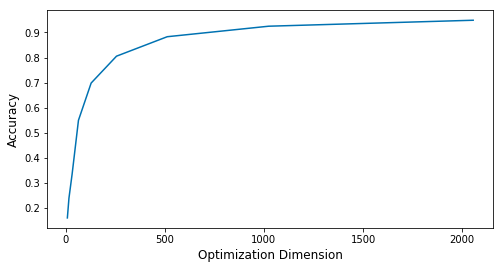

In [26]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_list, results)#, label='', linewidth=2)

# ax.set_ylim([560,740])
ax.set_xlabel('Optimization Dimension', fontsize='large')
ax.set_ylabel('Accuracy', fontsize='large')
# ax.legend(loc='best', prop={'size': 10})
# ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig('../output/imgs/DenseProjSmallFCNetMNIST.png', bbox='tight')
plt.show()

## CNN
* Implement a slightly more general model to compute intrinsic dimension for a CNN. 
* Use a sparse matrix instead of dense for projection to save memory

In [2]:
class IntrinsicNet(nn.Module):
    ''' Optimize subspace of parameters of network defined as  using dense projection.
    
    d: intrinsic dimension size to test
    layers: torch.nn.ModuleDict()
    config: dict with same keys as layers, containing 3 objects: 
            'type' (str): type of layer
            'params' (dict) : all the params to specify the layer (type, ...)
            'activation' (dict) : if there is an activation after the layer
    
    ??? This still won't work for resnets, or any other more complex network
    '''
    
    def __init__(self, d, layers, config, DEVICE='cuda'):
        super(IntrinsicNet, self).__init__()
        self.d = d
        self.layers = layers
        self.config = config
        self.opt_basis = nn.Parameter(torch.zeros(self.d).to(DEVICE), requires_grad=True)
        self.get_projection_matrix()
            
    def get_projection_matrix(self):
        self.D = 0
        for name, layer in self.layers.items():
            self.D += torch.prod(torch.tensor(layer.weight.size()))
            if layer.bias is not None:
                self.D += torch.prod(torch.tensor(layer.bias.size()))
            layer.requires_grad = False # none of the layers will be updated
        
        proj_matrix = nn.Parameter(torch.randn(self.D, self.d).to(DEVICE), requires_grad=False)
        proj_matrix = F.normalize(proj_matrix, dim=1, p=2)
        
        # Turn it into a nice format for a weight and bias matrix for each layer
        param_idx = 0
        self.projection = {}
        for name, layer in self.layers.items():
            self.projection[name] = {}
            n_weight_params = torch.prod(torch.tensor(layer.weight.size()))
            self.projection[name]['weight'] = proj_matrix[param_idx : param_idx + n_weight_params, :]
            self.projection[name]['weight'].requires_grad = False
            # also make sure the layers aren't trainable
            self.layers[name].weight.requires_grad = False
            param_idx += n_weight_params
            if layer.bias is not None:
                n_bias_params = torch.prod(torch.tensor(layer.bias.size()))
                self.projection[name]['bias'] = proj_matrix[param_idx : param_idx + n_bias_params, :]
                self.projection[name]['bias'].requires_grad = False
                # also make sure the layers aren't trainable
                self.layers[name].bias.requires_grad = False
                param_idx += n_bias_params
#         print(f'Model contains {self.D} params, but only optimizing a {self.d} dim subspace')

    def get_sparse_projection_matrix(self):
        
        M = SRP(weight_basis.size)._make_random_matrix(weight_basis.size,total_dim)
        fm=find(M)
        
        idx = torch.tensor(np.array([fm[0],fm[1]]).T)
        vals = torch.tensor(fm[2])
        torch.sparse.FloatTensor(i, v, (self.d, self.D)).to_dense()
        
        look here:
        https://github.com/uber-research/intrinsic-dimension/blob/9754ebe1954e82973c7afe280d2c59850f281dca/keras_ext/rproj_layers_util.py
        

    def get_layer_activation(self, name):
        mapping={'linear':F.linear,
                 'conv2d': F.conv2d,
                 'relu': F.relu
                }
        return mapping[name]


    def forward(self, x):
        for name, layer in self.layers.items():
            if self.config[name]['layer_type'] in ['linear', 'conv2d']:
                new_weight = self.layers[name].weight + torch.matmul(self.projection[name]['weight'], self.opt_basis
                                                           ).view(self.layers[name].weight.size())
                new_bias = self.layers[name].bias + torch.matmul(self.projection[name]['bias'], self.opt_basis
                                                           ).view(self.layers[name].bias.size())


                layer = self.get_layer_activation(self.config[name]['layer_type'])
                
                params = self.config[name]['params']
                
                params['weight'] = new_weight
                params['bias'] = new_bias
                    
            elif self.config[name]['layer_type'] == 'bn':
                pass
                
            activation = self.get_layer_activation(self.config[name]['activation'])
            
            
            x = layer(input=x, **params)
            if activation is not None:
                x = activation(x)
        x = x.squeeze()                
        return F.log_softmax(x, dim=1)

In [3]:
layers = torch.nn.ModuleDict()
layers['conv1'] = nn.Conv2d(1, 128, 5, stride=2, padding=2)
layers['conv2'] = nn.Conv2d(128, 256, 5, stride=2, padding=2)
layers['conv3'] = nn.Conv2d(256, 256, 7, stride=1, padding=0)
layers['conv4'] = nn.Conv2d(256, 10, 1, stride=1, padding=0)
config = {}
config['conv1'] = {'layer_type': 'conv2d',
                   'activation': 'relu', 
                   'params': {
                       'stride': 2, 'padding':2
                   } 
                  }
config['conv2'] = {'layer_type': 'conv2d',
                   'activation': 'relu', 
                   'params': {
                       'stride': 2, 'padding':2
                   }
                   }
                   
config['conv3'] = {'layer_type': 'conv2d',
                   'activation': 'relu',
                   'params': {
                       'stride': 1, 'padding':0
                   }
                   } 
config['conv4'] = {'layer_type': 'conv2d',
                   'activation': None,
                   'params': {
                       'stride': 1, 'padding':0
                   }
                   }
                   
train_loader, val_loader = mnist_loaders(PATH, bs=256)
model = IntrinsicNet(d=1024, layers=layers, config=config, DEVICE=DEVICE).to(DEVICE)
metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
print(f'CNN Acc with 1024 params: {metrics["val"]["best_acc"]}')

RuntimeError: CUDA out of memory. Tried to allocate 15.40 GiB (GPU 1; 11.91 GiB total capacity; 4.00 KiB already allocated; 11.42 GiB free; 2.00 MiB cached)

## Compare intrinsic dimension of a few CNNs

In [ ]:
vsmall_layers = torch.nn.ModuleDict()
vsmall_layers['conv1'] = nn.Conv2d(1, 64, 5, stride=2, padding=2)
vsmall_layers['conv2'] = nn.Conv2d(64, 100, 5, stride=2, padding=2)
vsmall_layers['conv3'] = nn.Conv2d(100, 100, 7, stride=1, padding=0)
vsmall_layers['conv4'] = nn.Conv2d(100, 10, 1, stride=1, padding=0)
vsmall_config = {}
vsmall_config['conv1'] = {'layer_type': 'conv2d',
                       'activation': 'relu', 
                       'params': {
                           'stride': 2, 'padding':2
                       } 
                      }
vsmall_config['conv2'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 2, 'padding':2
                           }
                           }

vsmall_config['conv3'] = {'layer_type': 'conv2d',
                           'activation': 'relu',
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           } 
vsmall_config['conv4'] = {'layer_type': 'conv2d',
                           'activation': None,
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           }

small_layers = torch.nn.ModuleDict()
small_layers['conv1'] = nn.Conv2d(1, 128, 5, stride=2, padding=2)
small_layers['conv2'] = nn.Conv2d(128, 256, 5, stride=2, padding=2)
small_layers['conv3'] = nn.Conv2d(256, 256, 7, stride=1, padding=0)
small_layers['conv4'] = nn.Conv2d(256, 10, 1, stride=1, padding=0)
small_config = {}
small_config['conv1'] = {'layer_type': 'conv2d',
                       'activation': 'relu', 
                       'params': {
                           'stride': 2, 'padding':2
                       } 
                      }
small_config['conv2'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 2, 'padding':2
                           }
                           }

small_config['conv3'] = {'layer_type': 'conv2d',
                           'activation': 'relu',
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           } 
small_config['conv4'] = {'layer_type': 'conv2d',
                           'activation': None,
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           }

med_layers = torch.nn.ModuleDict()
med_layers['conv1'] = nn.Conv2d(1, 128, 5, stride=2, padding=2)
med_layers['conv2'] = nn.Conv2d(128, 128, 5, stride=1, padding=2)
med_layers['conv3'] = nn.Conv2d(256, 512, 5, stride=2, padding=2)
med_layers['conv4'] = nn.Conv2d(512, 512, 7, stride=1, padding=0)
med_layers['conv5'] = nn.Conv2d(512, 10, 1, stride=1, padding=0)
med_config = {}
med_config['conv1'] = {'layer_type': 'conv2d',
                       'activation': 'relu', 
                       'params': {
                           'stride': 2, 'padding':2
                       } 
                      }
med_config['conv2'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 1, 'padding':2
                           }
                           }
med_config['conv3'] = {'layer_type': 'conv2d',
                           'activation': 'relu', 
                           'params': {
                               'stride': 2, 'padding':2
                           }
                           }
med_config['conv4'] = {'layer_type': 'conv2d',
                           'activation': 'relu',
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           } 
med_config['conv5'] = {'layer_type': 'conv2d',
                           'activation': None,
                           'params': {
                               'stride': 1, 'padding':0
                           }
                           }


results = {}
results['d_list'] = [8, 16, 32, 64, 128, 256, 512, 1024, 2056]
results['vsmall'] = []
results['small'] = []
results['med'] = []

for d in results['d_list']:
    train_loader, val_loader = mnist_loaders(PATH, bs=256)
    
    model = IntrinsicNet(d=1024, layers=vsmall_layers, config=vsmall_config, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    results['vsmall'].append(metrics["val"]["best_acc"])
    
    model = IntrinsicNet(d=1024, layers=small_layers, config=small_config, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    results['small'].append(metrics["val"]["best_acc"])
    
    model = IntrinsicNet(d=1024, layers=med_layers, config=med_config, DEVICE=DEVICE).to(DEVICE)
    metrics = train_net(model, train_loader, val_loader, epochs=30, verbose=0, device=DEVICE)
    results['med'].append(metrics["val"]["best_acc"])
          
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(d_list, results['vsmall'], label='', linewidth=2)
ax.plot(d_list, results['small'], label='', linewidth=2)
ax.plot(d_list, results['med'], label='', linewidth=2)
ax.set_xlabel('Optimization Subspace Dimension', fontsize='large')
ax.set_ylabel('Accuracy', fontsize='large')
ax.legend(loc='best', prop={'size': 10})
plt.savefig('../output/imgs/CNN_compare_MNIST.png', bbox='tight')
plt.show()